# Introduction

One of the interesting and important things to consider is the mask of the returned data (if applicable). SCRIP will always return an object of the MaskedArray class, however, it need not have a mask associated with it. 

Conversion between the ocean and the atmospheric grid is as one would expect. However, conversion from an ocean to the LL1 grid is not what one would expect in the sense that the output grid does not have a mask aassociated with it. This is because the LL1 grid that I have constructed and am using does not have a continental mask associated with it. Therefore, it just behaves like an atmospheric grid (like the FV1 which also does not have a mask). In light of this recognition, the conversion behaviour between GX1 and LL1 becomes easier to understand. 

NOTE: An important thing to note is that when SCRIP returns a grid which was obtained from a remapping of a grid which had a mask, then although the output grid does not have a mask, the cells in the output grid, which would have been masked is set to zero. 

In [1]:
%%HTML
<style>
div.prompt {display:none}
</style>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib as mpl
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt

In [4]:
import sys, os
import PySCRIP as scrip
from PySCRIP.config import PySCRIPConfig

In [5]:
fv1data = {'file':'testdata/cesmpifv1mts_cam_mapping_testdata.nc', 'var':'TS'}
gx1data = {'file':'testdata/cesmpifv1mts_pop_mapping_testdata.nc', 'var':'SSH'}

In [6]:
a = PySCRIPConfig()

# Conversions

## FV1 to GX1

In [7]:
ncfile = Dataset(fv1data['file'], "r")
fv1_src_data = ncfile.variables[fv1data['var']][:,:]
ncfile.close()

map_ = a.getmap('cesmpifv1mts', 'conservative','fv1', 'gx1')
gx1_dest_data = scrip.remap(fv1_src_data, map_.fname, map_.format)

In Python versions 3.5 and less, fv1_src_data should be of type "numpy.ndarray". For later versions, it should be of type "numpy.ma.core.MaskedArray"

In [8]:
print(type(fv1_src_data))
print(type(gx1_dest_data))

<class 'numpy.ndarray'>
<class 'numpy.ma.core.MaskedArray'>


In [9]:
print(gx1_dest_data.mask)

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


The stats function prints some statistics of the distribution of data between the input and the output grids, and plots histograms. 

NOTE: The statistics can be misleading when masks are involved! Because masks, well... mask values, so distrubutions will be different.

In [25]:
def stats(arr1, arr2, range=None):
    print("Array shapes:  {0}     {1}".format(arr1.squeeze().shape, arr2.shape))
    print("Minimum     :  {0}     {1}".format(arr1.min(), arr2.min()))
    print("Mean        :  {0}     {1}".format(arr1.mean(), arr2.mean()))    
    print("Maximum     :  {0}     {1}".format(arr1.max(), arr2.max()))    
    print("Std         :  {0}     {1}".format(arr1.std(), arr2.std()))
    
    if sys.version_info.minor <= 5:
        kwargs = {"normed": True}
    else:
        kwargs = {"density": True}
    
    fig, (ax1, ax2) = plt.subplots(figsize=(14,5), nrows=1, ncols=2)
    ax1.hist(arr1.flatten(), bins=30, range=range, **kwargs)
    ax1.set_title("Source Array")

    ax2.hist(arr2.flatten(), bins=30, range=range, **kwargs)
    ax2.set_title("Destination Array")
    plt.show()


Array shapes:  (192, 288)     (384, 320)
Minimum     :  213.0178985595703     237.13083470562123
Mean        :  275.5151062011719     287.72348500915103
Maximum     :  309.005615234375     303.75401136610355
Std         :  23.637895584106445     16.0256233079597


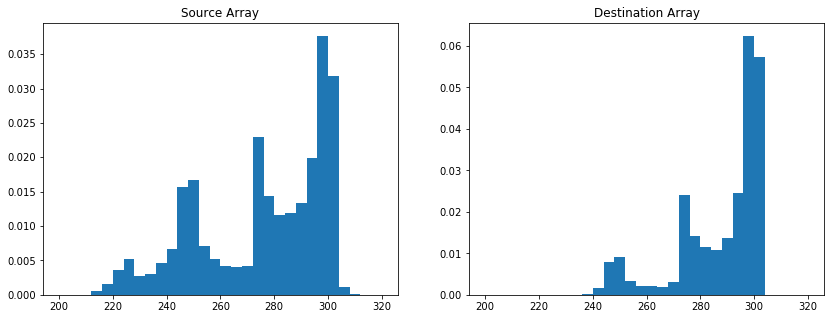

In [26]:
stats(fv1_src_data, gx1_dest_data, range=(200, 320))

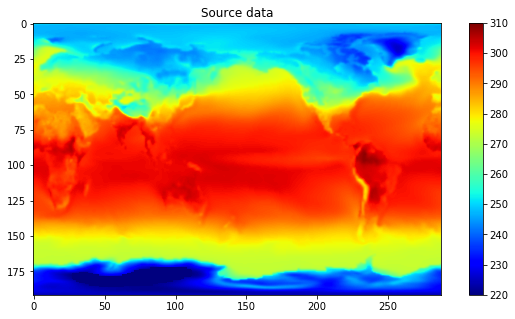

In [27]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_src_data.squeeze()), vmin=220, vmax=310, cmap=mpl.cm.jet, interpolation="bicubic")
plt.colorbar()
plt.title("Source data")
plt.show()

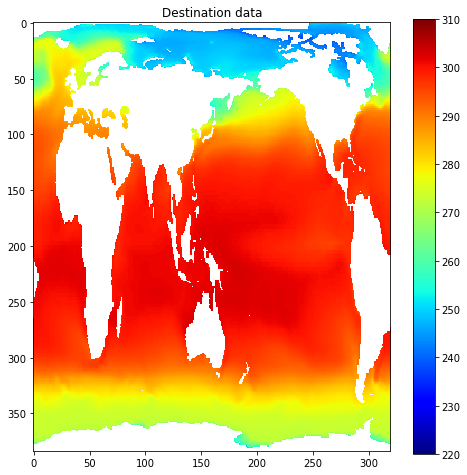

In [28]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_dest_data), vmin=220, vmax=310, cmap=mpl.cm.jet, interpolation="none")
plt.colorbar()
plt.title("Destination data")
plt.show()

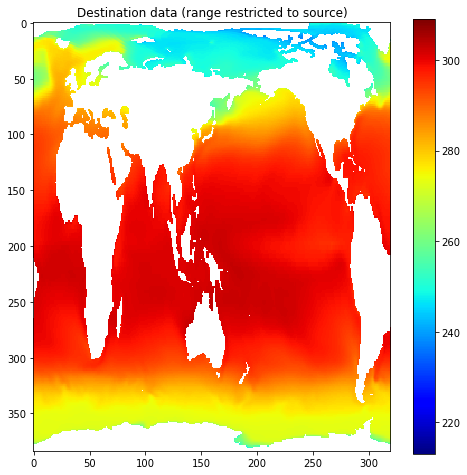

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_dest_data), vmin=fv1_src_data.min(), vmax=fv1_src_data.max(), cmap=mpl.cm.jet)
plt.colorbar()
plt.title("Destination data (range restricted to source)")
plt.show()

## GX1 to FV1

In [30]:
ncfile = Dataset(gx1data['file'], "r")
gx1_src_data = ncfile.variables[gx1data['var']][:,:]
ncfile.close()

map_ = a.getmap('cesmpifv1mts', 'conservative','gx1', 'fv1')
fv1_dest_data = scrip.remap(gx1_src_data, map_.fname, map_.format)

Here we see that the FV1 data that is returned by SCRIP is of the class maskedarray, this is what we would expect since the input data is masked. 

In [31]:
print(type(gx1_src_data))
print(type(fv1_dest_data))

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


In [32]:
print(gx1_src_data.mask)

[[[ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  ..., 
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]]]


However, since FV1 is an atmosphere grid which has no mask associated with it, the mask attribute is actually just a boolean and is False, rather than the 2D mask that we might have expected. 

In [33]:
print(fv1_dest_data.mask)

False


Array shapes:  (384, 320)     (192, 288)
Minimum     :  -237.68064880371094     -236.31864999185686
Mean        :  -9.51669966774688     -16.675132200513026
Maximum     :  121.562255859375     119.59796317713963
Std         :  82.96186316525069     71.43578670265595


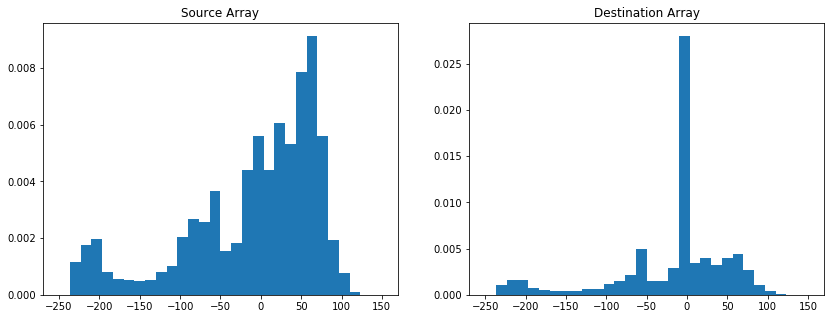

In [34]:
stats(gx1_src_data, fv1_dest_data, range=(-250,150))

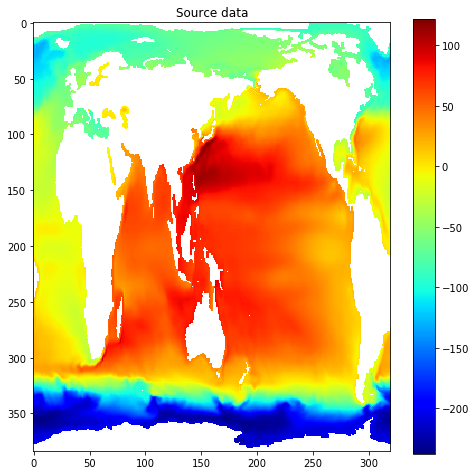

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_src_data.squeeze()), cmap=mpl.cm.jet)
plt.colorbar()
plt.title("Source data")
plt.show()

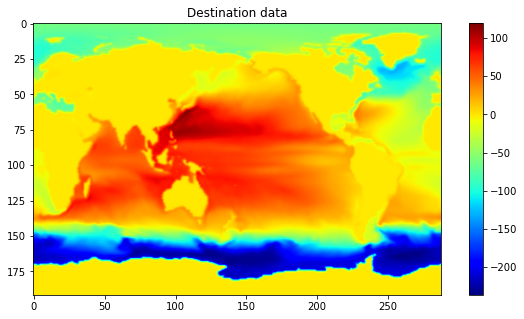

In [36]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_dest_data), cmap=mpl.cm.jet, interpolation="bicubic")
plt.colorbar()
plt.title("Destination data")
plt.show()

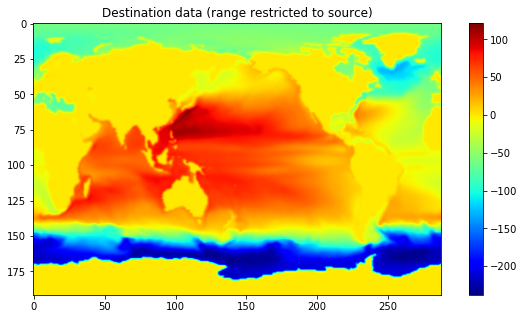

In [37]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_dest_data), vmin=gx1_src_data.min(), vmax=gx1_src_data.max(), cmap=mpl.cm.jet, interpolation="bicubic")
plt.colorbar()
plt.title("Destination data (range restricted to source)")
plt.show()

In [38]:
gx1_src_data.mask

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]], dtype=bool)

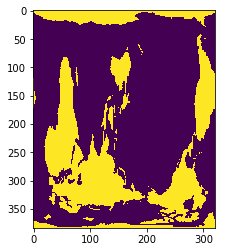

In [39]:
plt.figure()
plt.imshow(gx1_src_data.mask.squeeze().astype('f'))
plt.show()

## FV1 to LL1

In [40]:
map_ = a.getmap('cesmpifv1mts', 'conservative','fv1', 'll1')
ll1_dest_data_from_fv1 = scrip.remap(fv1_src_data, map_.fname, map_.format)

We see here that SCRIP again returns an array of the MaskedArray class

In [41]:
print(type(fv1_src_data))
print(type(ll1_dest_data_from_fv1))

<class 'numpy.ndarray'>
<class 'numpy.ma.core.MaskedArray'>


But, since there is no mask associated with the data (we are working with atmospheric data which will not have a mask on any atomospheric grid), the mask attribute is a boolean value and is False. 

In [42]:
print(ll1_dest_data_from_fv1.mask)

False


Array shapes:  (192, 288)     (180, 360)
Minimum     :  213.0178985595703     213.43195672270986
Mean        :  275.5151062011719     275.72570713222075
Maximum     :  309.005615234375     308.67081472964617
Std         :  23.637895584106445     23.486790569009866


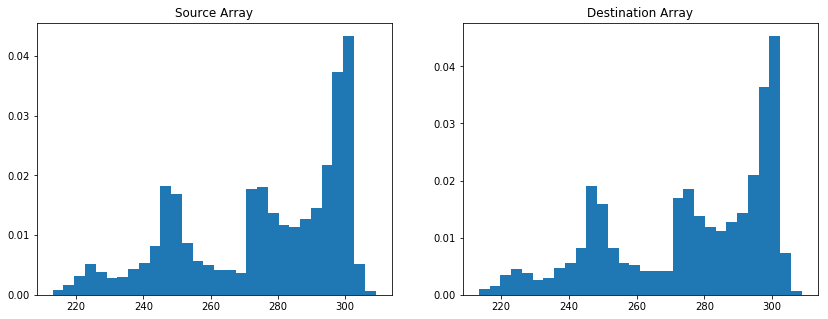

In [43]:
stats(fv1_src_data, ll1_dest_data_from_fv1)

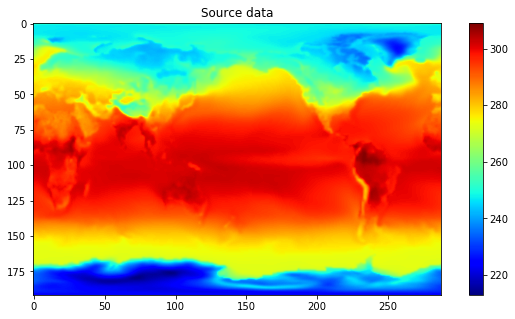

In [44]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_src_data.squeeze()), cmap=mpl.cm.jet, interpolation="bicubic")
plt.colorbar()
plt.title("Source data")
plt.show()

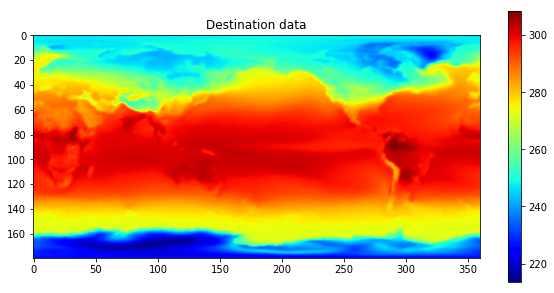

In [45]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(ll1_dest_data_from_fv1), cmap=mpl.cm.jet, interpolation="bicubic")
plt.colorbar()
plt.title("Destination data")
plt.show()

## GX1 to LL1

In [46]:
map_ = a.getmap('cesmpifv1mts', 'conservative','gx1', 'll1')

ll1_dest_data_from_gx1 = scrip.remap(gx1_src_data, map_.fname, map_.format)
# ll1_dest_data_from_gx1 = np.ma.MaskedArray(ll1_dest_data_from_gx1, mask=(ll1_dest_data_from_gx1 == 0))

This is an interesting case. The input data is clearly a masked array, and as usual SCRIP returns a MaskedArray class. But the returned data does not actually have a mask! 

In [47]:
print(type(gx1_src_data))
print(type(ll1_dest_data_from_gx1))
print(ll1_dest_data_from_gx1.mask)

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
False


Array shapes:  (384, 320)     (180, 360)
Minimum     :  -237.68064880371094     -236.3520792463906
Mean        :  -9.51669966774688     -17.750620157309367
Maximum     :  121.562255859375     119.50856271577814
Std         :  82.96186316525069     73.38577102594724


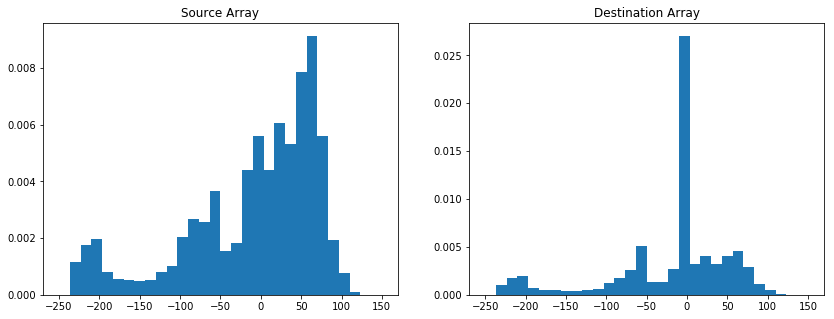

In [48]:
stats(gx1_src_data, ll1_dest_data_from_gx1, range=(-250,150))

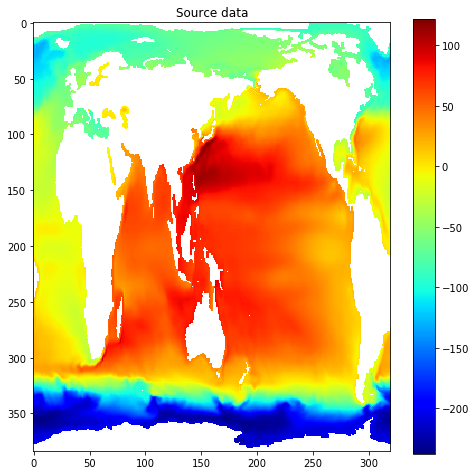

In [49]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_src_data.squeeze()), cmap=mpl.cm.jet)
plt.colorbar()
plt.title("Source data")
plt.show()

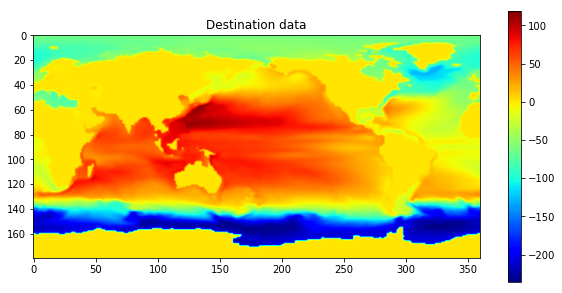

In [50]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(ll1_dest_data_from_gx1), cmap=mpl.cm.jet, interpolation="bicubic")
plt.colorbar()
plt.title("Destination data")
plt.show()

In [51]:
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')

/Users/dchandan/local/miniconda3/envs/Oldresc/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/dchandan/local/miniconda3/envs/Oldresc/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/dchandan/local/miniconda3/envs/Oldresc/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/dchandan/local/miniconda3/envs/Oldresc/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_colo

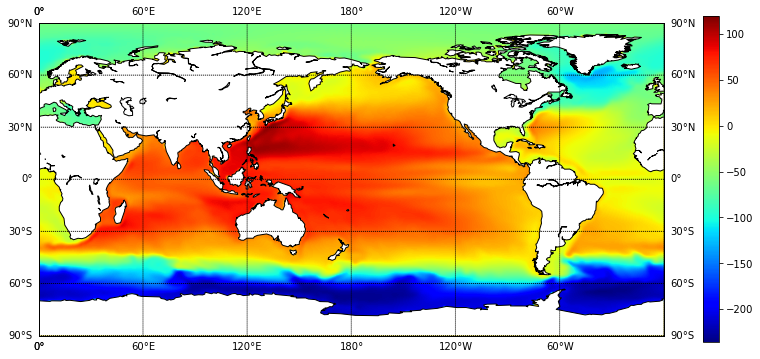

In [52]:
plt.figure(figsize=(14,6))
m.imshow(ll1_dest_data_from_gx1.data, cmap=mpl.cm.jet, interpolation="bicubic")
m.drawcoastlines()
m.fillcontinents(color='white')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.), labels=[True, True, False, False])
m.drawmeridians(np.arange(-180.,181.,60.), labels=[False, False, True, True])
m.drawmapboundary()
plt.colorbar()

In [53]:
mpl.__version__

'2.0.2'